# Time series analysis using the Fourier Transform for DInSAR
This analysis is based on https://github.com/MorcilloSanz/fourier-analysis

In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

%matplotlib inline

Load the time series of 4 points of the same place for SBAS and EGMS

In [287]:
time_series_psi = np.load("data/time_series_psi.npy")
dates_psi = pd.read_csv("data/dates_psi.csv", header=None).to_numpy()[1:].flatten()
dates_psi = pd.to_datetime(dates_psi)

Since there is a missmatch between the dates, we need to adjust the time window for both time series

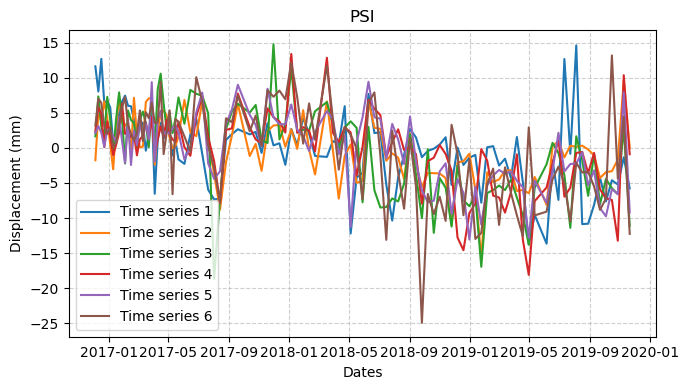

In [288]:
fig, ax = plt.subplots(figsize=(7, 4))

for i, time_series in enumerate(time_series_psi):
    ax.plot(dates_psi, time_series, label=f"Time series {i + 1}")

ax.set_title('PSI')
ax.set_xlabel('Dates')
ax.set_ylabel('Displacement (mm)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

fig.tight_layout()
plt.show()

For a better understading we will decompose the time series using the Fourier Transform

In [289]:
ft_psi = []
for time_series in time_series_psi:
    ft_psi.append(fft(time_series))

ft_psi = np.array(ft_psi)

step_size = 4 / ft_psi.shape[1]  # Each step is 4 months
frequencies = fftfreq(ft_psi.shape[1], step_size)

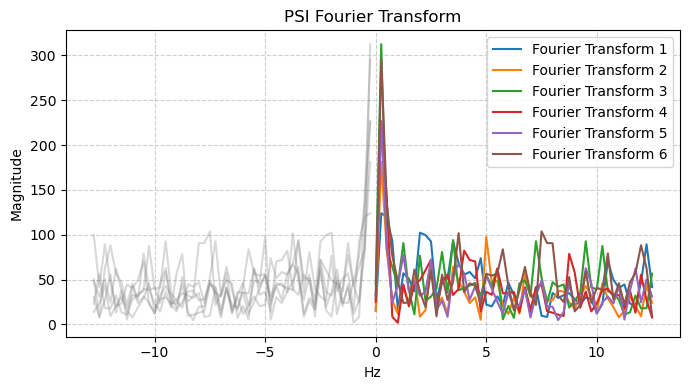

In [290]:
fig, ax = plt.subplots(figsize=(7, 4))

for i, ft in enumerate(ft_psi):
    magnitude = np.abs(ft)
    ax.plot(frequencies[frequencies >= 0], magnitude[frequencies >= 0], label=f'Fourier Transform {i + 1}')
    ax.plot(frequencies[frequencies < 0], magnitude[frequencies < 0], color='gray', alpha=0.3)

ax.set_title('PSI Fourier Transform')
ax.set_xlabel('Hz')
ax.set_ylabel('Magnitude')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

Now, we can filter by intervals of frequencies for extracting trends

In [291]:
d_omega = 0.4
n_intervals = 6
intervals = []

for i in range(0, n_intervals-1):
    interval = (i * d_omega, (i + 1) * d_omega)
    intervals.append(interval)

intervals.append((intervals[-1][1], max(frequencies)))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'violet']

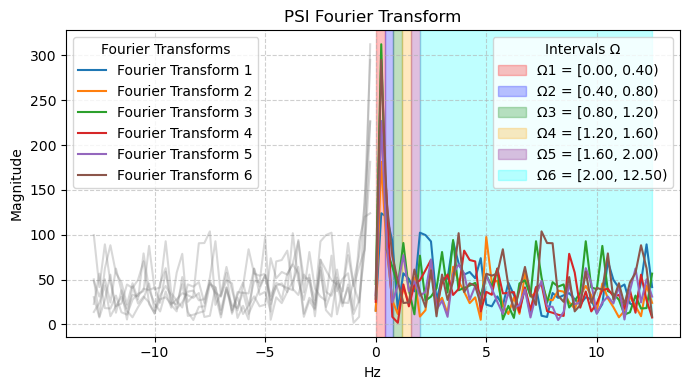

In [292]:
fig, ax = plt.subplots(figsize=(7, 4))

lines_ft = [] 
labels_ft = []

for i, ft in enumerate(ft_psi):
    magnitude = np.abs(ft)

    line, = ax.plot(
        frequencies[frequencies >= 0],
        magnitude[frequencies >= 0],
        label=f'Fourier Transform {i + 1}'
    )
    lines_ft.append(line)
    labels_ft.append(f'Fourier Transform {i + 1}')

    ax.plot(
        frequencies[frequencies < 0],
        magnitude[frequencies < 0],
        color='gray',
        alpha=0.3
    )

patches_intervals = []
labels_intervals = []

for i, interval in enumerate(intervals):
    color = colors[i % len(colors)]
    patch = ax.axvspan(
        interval[0], interval[1],
        alpha=0.25,
        color=color,
        label=f'Ω{i + 1} = [{interval[0]:.2f}, {interval[1]:.2f})'
    )
    patches_intervals.append(patch)
    labels_intervals.append(f'Ω{i + 1} = [{interval[0]:.2f}, {interval[1]:.2f})')

# Legend 1
legend1 = ax.legend(lines_ft, labels_ft, loc='upper left', title='Fourier Transforms')
ax.add_artist(legend1)

# Legend 2
legend2 = ax.legend(patches_intervals, labels_intervals, loc='upper right', title='Intervals Ω')

ax.set_title('PSI Fourier Transform')
ax.set_xlabel('Hz')
ax.set_ylabel('Magnitude')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [293]:
def filter(ft: np.array) -> tuple[list, list]:

    F_hat: list[np.array] = []
    psi: list[np.array] = []

    for low, high in intervals:

        F_hat_i = ft.copy()

        mask_i = (np.abs(frequencies) >= low) & (np.abs(frequencies) < high)
        F_hat_i[~mask_i] = 0
        psi_i = ifft(F_hat_i).real

        F_hat.append(F_hat_i)
        psi.append(psi_i)

    F_hat = np.array(F_hat)
    psi = np.array(psi)

    return F_hat, psi


F_hat_psi = []
psi_psi = []

for ft in ft_psi:
    F_hat_psi_i, psi_psi_i = filter(ft)
    F_hat_psi.append(F_hat_psi_i)
    psi_psi.append(psi_psi_i)

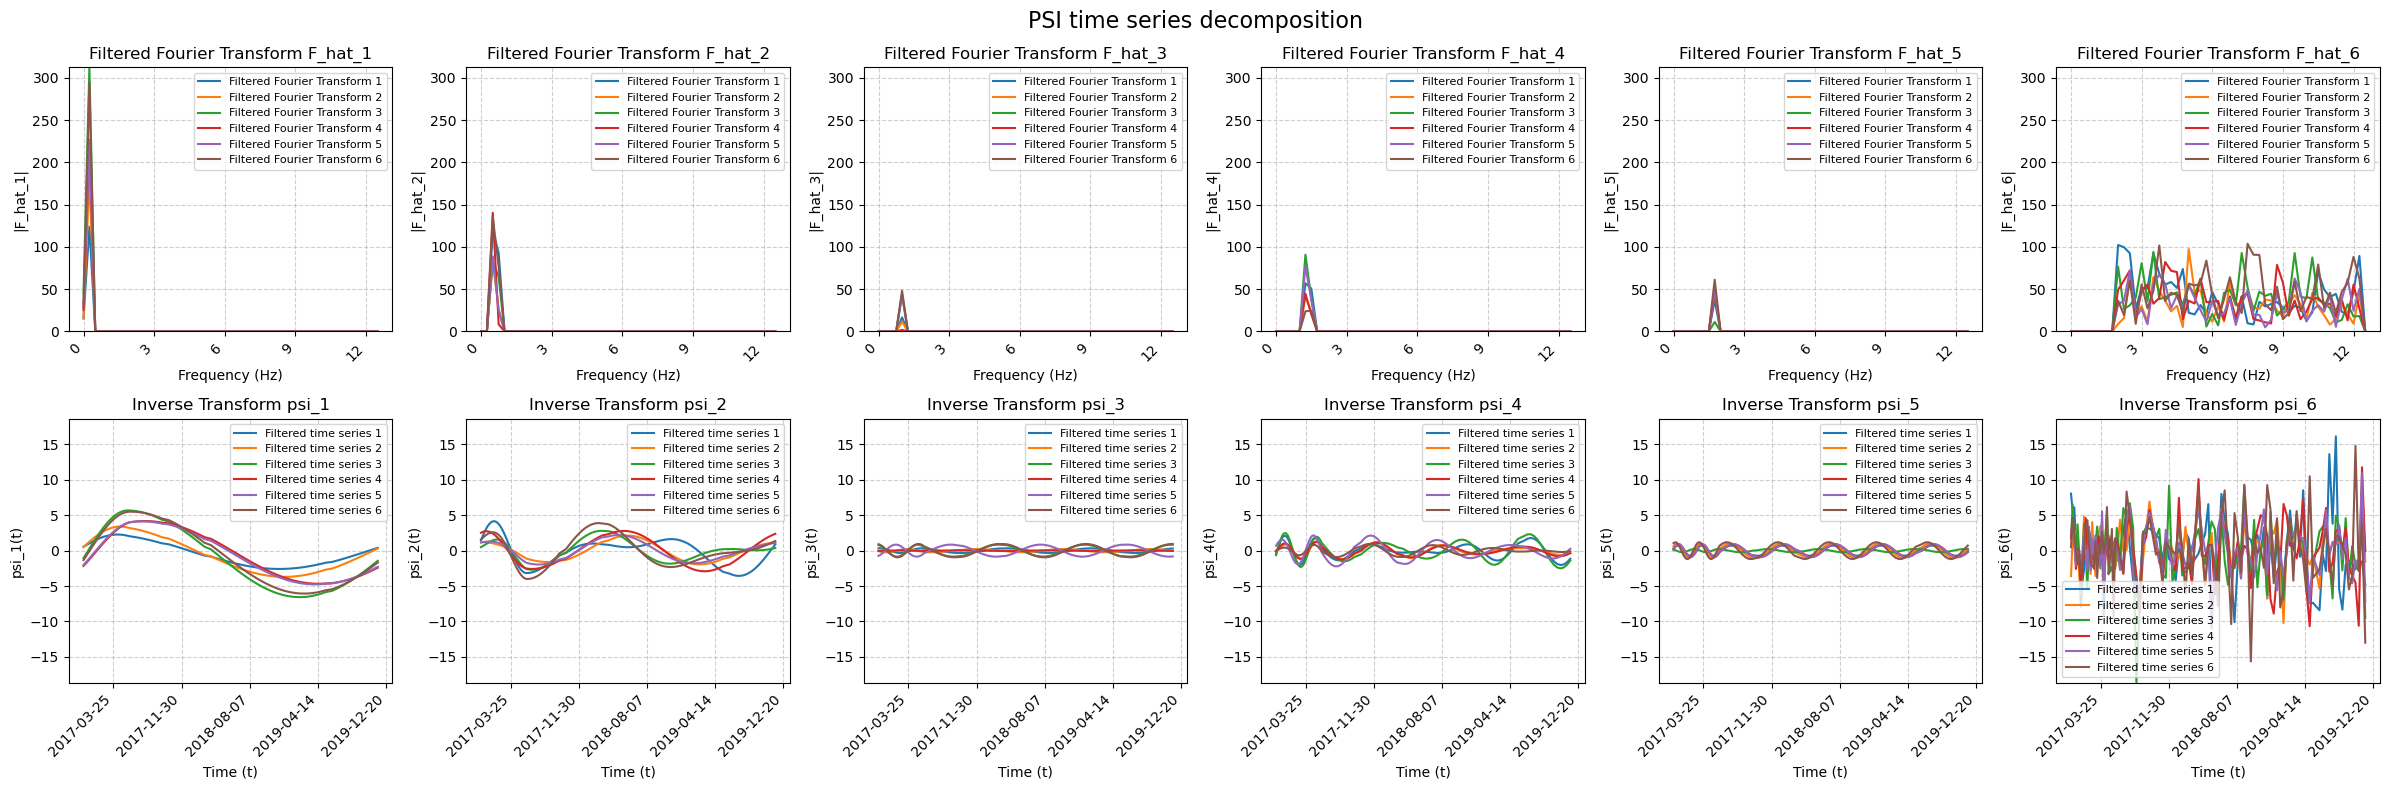

In [294]:
def plot_filtered(F_hat_list, psi_list, title="") -> None:

    n_sbas = len(F_hat_list)
    n_components = F_hat_list[0].shape[0]

    # Scales
    max_F = max(np.max(np.abs(F_hat)) for F_hat in F_hat_list)
    max_psi = max(np.max(np.abs(psi)) for psi in psi_list)

    fig, axes = plt.subplots(2, n_components, figsize=(4 * n_components, 8))
    fig.suptitle(title, fontsize=16)

    for k in range(n_components):

        # F_hat
        axF = axes[0, k]
        axF.set_title(f"Filtered Fourier Transform F_hat_{k+1}")
        axF.set_ylim(0, max_F)
        axF.grid(True, linestyle='--', alpha=0.6)

        pos = frequencies >= 0
        neg = frequencies < 0

        for i in range(n_sbas):
            axF.plot(
                frequencies[pos],
                np.abs(F_hat_list[i][k, pos]),
                label=f"Filtered Fourier Transform {i+1}"
            )

        axF.legend(fontsize=8)
        axF.set_xlabel("Frequency (Hz)")
        axF.set_ylabel(f"|F_hat_{k+1}|")
        axF.xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.setp(axF.get_xticklabels(), rotation=45, ha="right")

        # psi(t)
        axT = axes[1, k]
        axT.set_title(f"Inverse Transform psi_{k+1}")
        axT.set_ylim(-max_psi, max_psi)
        axT.grid(True, linestyle='--', alpha=0.6)

        for i in range(n_sbas):
            axT.plot(
                dates_psi,
                psi_list[i][k],
                label=f"Filtered time series {i+1}"
            )

        axT.legend(fontsize=8)
        axT.set_xlabel("Time (t)")
        axT.set_ylabel(f"psi_{k+1}(t)")
        axT.xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.setp(axT.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

plot_filtered(F_hat_psi, psi_psi, "PSI time series decomposition")

We can see that the last intervals of frequencies are noise. And the rest contain the DETERMINISTIC functions that define the whole deformation. We can only sum the deterministic functions to get rid of the noise

In [295]:
determinisic_functions = 5
smooth_time_series_psi = []

for i, time_series in enumerate(time_series_psi):

    smooth_time_series = np.zeros(time_series.shape)
    for j in range(0, determinisic_functions):
        smooth_time_series += psi_psi[i][j]

    smooth_time_series_psi.append(smooth_time_series)

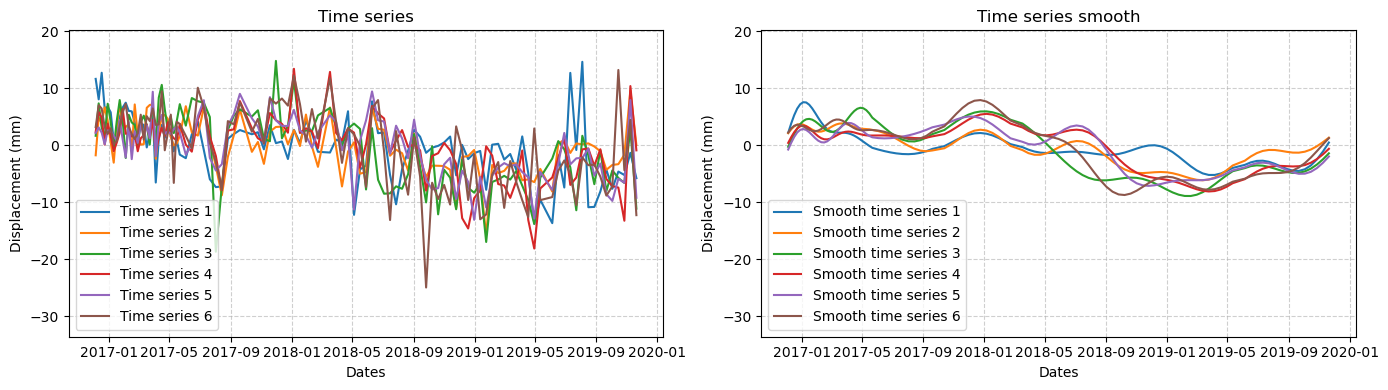

In [296]:
def plot_smooth() -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Original
    for i, time_series in enumerate(time_series_psi):
        axes[0].plot(dates_psi, time_series, label=f"Time series {i + 1}")

    axes[0].set_title('Time series')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Displacement (mm)')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Smooth
    for i, smooth_time_series in enumerate(smooth_time_series_psi):
        axes[1].plot(dates_psi, smooth_time_series, label=f"Smooth time series {i + 1}")

    axes[1].set_title(f'Time series smooth')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Displacement (mm)')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    # Scale
    all_series = time_series_psi + smooth_time_series_psi
    y_min = min([series.min() for series in all_series])
    y_max = max([series.max() for series in all_series])

    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()


plot_smooth()

Since we see a peak in every Fourier Transform in the first inverval that corresponds with the sesonality, we can just remove it from the smooth time series in order to get rid of the noise and seasonality and get the deformation caused by different natural/artificial processes.

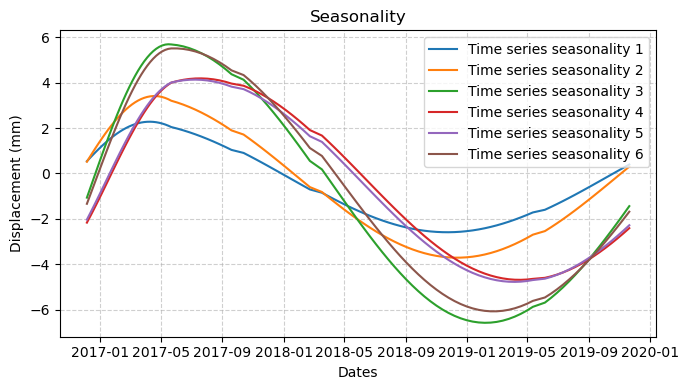

In [297]:
fig, ax = plt.subplots(figsize=(7, 4))

for i, time_series in enumerate(time_series_psi):
    ax.plot(dates_psi, psi_psi[i][0], label=f"Time series seasonality {i + 1}")

ax.set_title('Seasonality')
ax.set_xlabel('Dates')
ax.set_ylabel('Displacement (mm)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

fig.tight_layout()
plt.show()

In [298]:
deformation_time_series_psi = []

for i, smooth_time_series in enumerate(smooth_time_series_psi):
    deformation_time_series_psi_i = smooth_time_series - psi_psi[i][0]
    deformation_time_series_psi.append(deformation_time_series_psi_i)

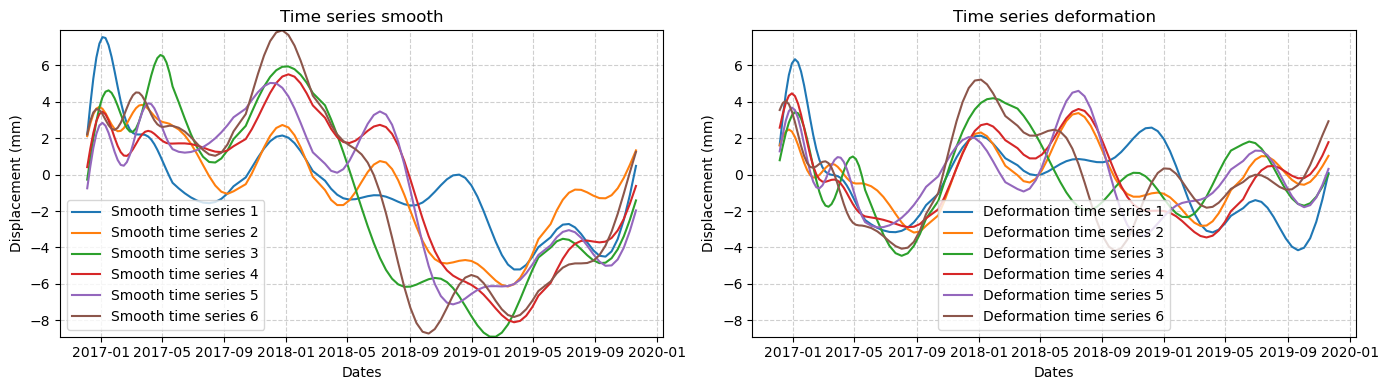

In [299]:
def plot_deformation() -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Smooth
    for i, smooth_time_series in enumerate(smooth_time_series_psi):
        axes[0].plot(dates_psi, smooth_time_series, label=f"Smooth time series {i + 1}")

    axes[0].set_title(f'Time series smooth')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Displacement (mm)')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Deformation
    for i, deformation_time_series in enumerate(deformation_time_series_psi):
        axes[1].plot(dates_psi, deformation_time_series, label=f"Deformation time series {i + 1}")

    axes[1].set_title(f'Time series deformation')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Displacement (mm)')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    # Scale
    all_series =  smooth_time_series_psi + deformation_time_series_psi
    y_min = min([series.min() for series in all_series])
    y_max = max([series.max() for series in all_series])

    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

plot_deformation()